In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%time
!unzip '/content/drive/MyDrive/Colab Notebooks/Butterfly classifier/butterfly.zip'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: butterfly/train/COMMON BANDED AWL/Image_6185.jpg  
  inflating: butterfly/train/COMMON BANDED AWL/Image_6190.jpg  
  inflating: butterfly/train/COMMON BANDED AWL/Image_6448.jpg  
  inflating: butterfly/train/COMMON BANDED AWL/Image_683.jpg  
  inflating: butterfly/train/COMMON BANDED AWL/Image_845.jpg  
   creating: butterfly/train/COMMON WOOD-NYMPH/
  inflating: butterfly/train/COMMON WOOD-NYMPH/Image_1046.jpg  
  inflating: butterfly/train/COMMON WOOD-NYMPH/Image_1104.jpg  
  inflating: butterfly/train/COMMON WOOD-NYMPH/Image_112.jpg  
  inflating: butterfly/train/COMMON WOOD-NYMPH/Image_1142.jpg  
  inflating: butterfly/train/COMMON WOOD-NYMPH/Image_1277.jpg  
  inflating: butterfly/train/COMMON WOOD-NYMPH/Image_1309.jpg  
  inflating: butterfly/train/COMMON WOOD-NYMPH/Image_1346.jpg  
  inflating: butterfly/train/COMMON WOOD-NYMPH/Image_1358.jpg  
  inflating: butterfly/train/COMMON WOOD-NYMP

In [ ]:
# !ls '/content/drive/MyDrive/Colab Notebooks/Butterfly classifier'

In [ ]:
# !ls '/content/butterfly/test'

In [3]:
### Chargement des librairies

import numpy
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import glob
import torch.nn.functional as F

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],
                        [0.5,0.5,0.5])

])

In [31]:
## Dataloader

train_path='/content/butterfly/train'
val_path='/content/butterfly/val'
train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64,
    shuffle=True
)

val_loader = DataLoader(
    torchvision.datasets.ImageFolder(val_path,transform=transformer),
    batch_size=64,
    shuffle=False
)

In [7]:
root = pathlib.Path(train_path)

classes = sorted(j.name.split('/')[-1] for j in root.iterdir())
len(classes)

75

In [8]:
C1F = []
C2F = []
C3F = []
C4F = []

In [32]:
## CC

class ConvNet(nn.Module):
  def __init__(self,num_classes=75):
    super(ConvNet,self).__init__()

    self.conv1 = nn.Conv2d(3,16,3,padding=1)
    self.conv2 = nn.Conv2d(16,32,3,padding=1)
    self.conv3 = nn.Conv2d(32,64,3,padding=1)
    self.pool1 = nn.MaxPool2d(2,2)
    self.pool2 = nn.MaxPool2d(2,2)
    self.pool3 = nn.MaxPool2d(2,2)

    self.fc1 = nn.Linear(64*28*28,128)
    self.fc2 = nn.Linear(128,num_classes)

  def forward(self,x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool1(x)
    C1F.append(x)
    # print("shape pool1==========>",x.shape)
    x = self.conv2(x)
    # print("shape conv2==========>",x.shape)
    x = F.relu(x)
    x = self.pool2(x)
    C2F.append(x)
    # print("shape pool2==========>",x.shape)
    x = self.conv3(x)
    # print("shape conv3==========>",x.shape)
    x = F.relu(x)
    x = self.pool3(x)
    C3F.append(x)


    # print("shape pool3==========>",x.shape)
    x = x.view(-1,64*28*28)
    # print("shape flatten==========>",x.shape)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)

    return x



In [33]:
model = ConvNet(num_classes=75).to(device)
model

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=75, bias=True)
)

In [11]:
optimizer = Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()

In [13]:
EPOCHS = 20

In [12]:
train_count = len(glob.glob(train_path+'/**/*.jpg'))
val_count = len(glob.glob(val_path+'/**/*.jpg'))
val_count

650

In [34]:
### training our model

best_acc = 0.0

loss_history = []
validation_accuracy_history = []
for epoch in range(EPOCHS):
  ## training
  model.train()

  train_acc = 0.0
  train_loss = 0.0


  for i,(images,labels) in enumerate(train_loader):
    if torch.cuda.is_available():
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())

    optimizer.zero_grad()

    outputs = model(images)

    loss = loss_function(outputs,labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.cpu().data*images.size(0)
    _,prediction = torch.max(outputs.data,1)

    train_acc += int(torch.sum(prediction==labels.data))

  train_acc = train_acc/train_count
  train_loss = train_loss/train_count
  loss_history.append(train_loss)









  ## evalutation
  model.eval()

  val_acc = 0.0
  for i,(images,labels) in enumerate(val_loader):
    if torch.cuda.is_available():
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())

    outputs = model(images)
    _,prediction = torch.max(outputs.data,1)
    val_acc += int(torch.sum(prediction==labels.data))


  val_acc = val_acc/val_count
  validation_accuracy_history.append(val_acc)
  print(f'Epoch: {epoch+1} Train Loss: {train_loss:.4f} Train Accuracy: {train_acc:.4f} Validation Accuracy: {val_acc:.2f}')

  if val_acc > best_acc:
    torch.save(model.state_dict(),'best_model.pt')
    best_acc = val_acc




KeyboardInterrupt: ignored

In [ ]:
from io import open
from PIL import Image
import cv2

In [ ]:
def prediction(img_path,transformer):
  image = Image.open(img_path)

  image_tensor = transformer(image).float()

  image_tensor = image_tensor.unsqueeze(0)

  inputI = Variable(image_tensor.cuda())

  output = model(inputI)
  # print("sortie",)
  index = output.data.cpu().numpy().argmax()

  return classes[index]

In [ ]:
image = Image.open('/content/butterfly/images.jpg')
image = transformer(image).float()
image = image.unsqueeze(0)
image = Variable(image.cuda())
output = model(image)
idx = output.data.cpu().numpy().argmax()
classes[idx]


FileNotFoundError: ignored

In [ ]:
test_path = '/content/butterfly/test'
image_path = glob.glob(test_path+'/*.jpg')


In [ ]:
pred_dict = {}

for i in image_path:
  pred_dict[i[i.rfind('/')+1:]] = prediction(i,transformer)

In [ ]:
pred_dict['Image_241.jpg']

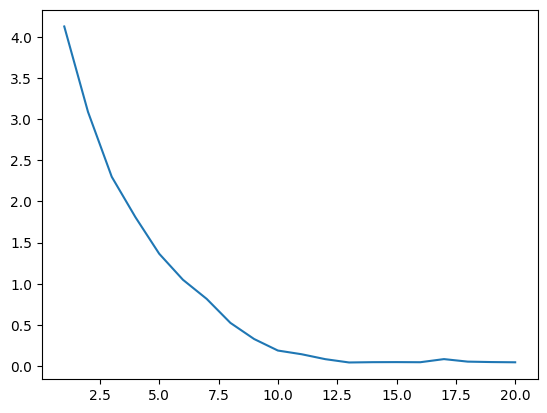

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, EPOCHS + 1), loss_history, label='training Loss')
plt.show()

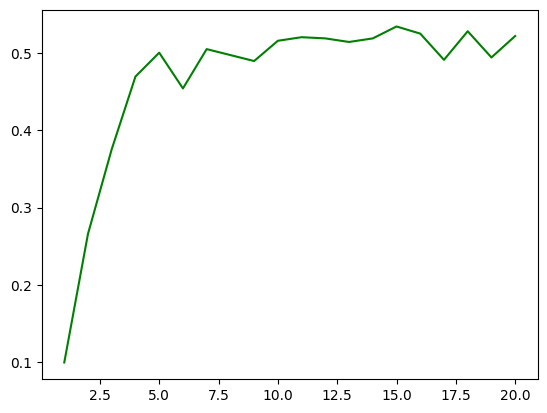

In [ ]:
plt.plot(range(1, EPOCHS + 1), validation_accuracy_history, label='validation Loss',c='g')

In [16]:
import matplotlib.pyplot as plt


In [ ]:
 C1F[0].shape

torch.Size([256, 16, 112, 112])

In [21]:
def showIm(data,channel):
  batch_images = data[18]
  batch_images_cpu = batch_images.cpu()

  # Afficher quelques images du batch
  num_images_to_display = 5  # Changer le nombre d'images à afficher
  # num_channels_to_display = 1  # Choisir le nombre de canaux à afficher

  plt.figure(figsize=(12, 6))
  for i in range(num_images_to_display):
      plt.subplot(1, num_images_to_display, i + 1)
      # Sélectionner une image du batch et du canal spécifique pour l'affichage
      image_to_display = batch_images_cpu[i, channel].detach().numpy()  # Convertir en NumPy array
      plt.imshow(image_to_display, cmap='gray')  # Afficher chaque image en niveaux de gris
      plt.title(f'Image {i + 1}')
      plt.axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
image = C3F[1]
image = image[1]
image.shape

torch.Size([64, 28, 28])

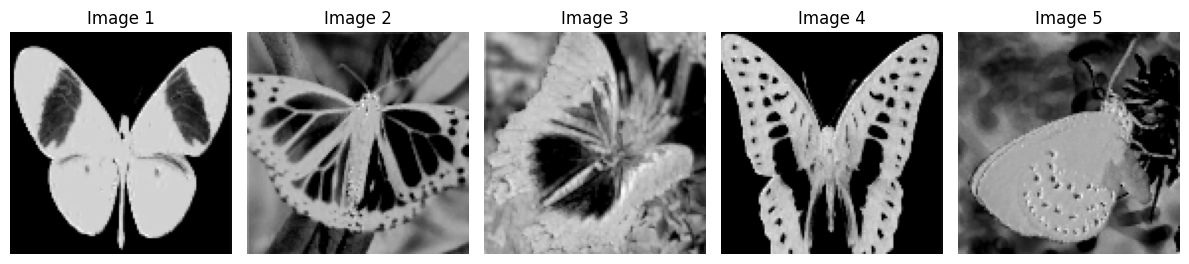

In [38]:
showIm(C1F,2)

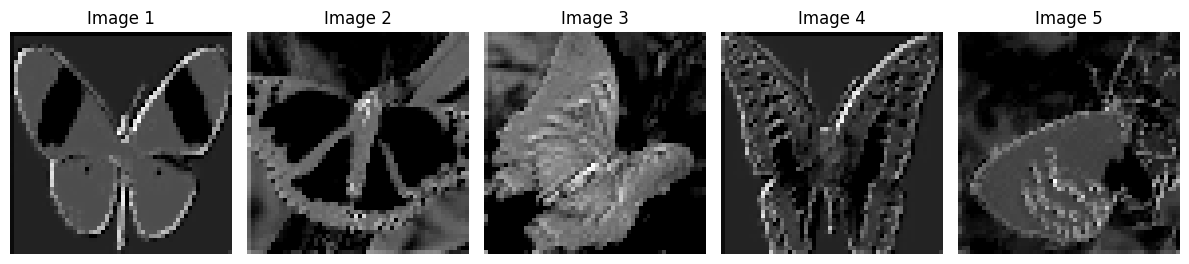

In [39]:
showIm(C2F,2)

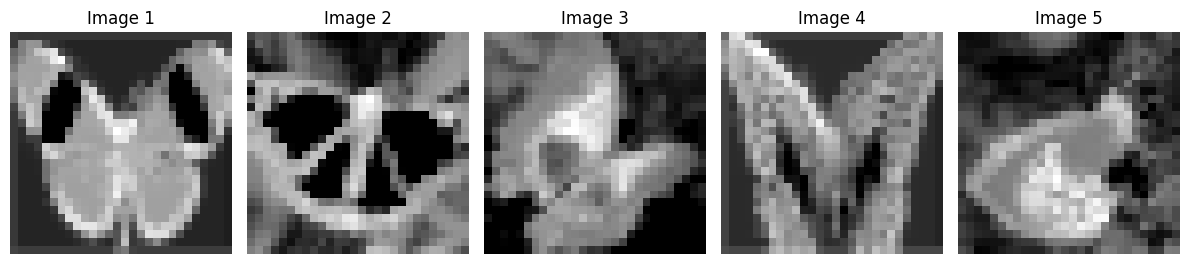

In [40]:
showIm(C3F,2)